# interaction with external model

## load necessary packages

In [1]:
import supy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
sp.__version__

'2018.11.28dev'

## run `SUEWS` with default settings

In [2]:
df_state_init, df_forcing = sp.load_SampleData()

In [3]:
%%time
df_output_m, df_state_m = sp.run_supy(df_forcing, df_state_init)
df_output_def = df_output_m.loc[1,'SUEWS']

CPU times: user 21.8 s, sys: 791 ms, total: 22.6 s
Wall time: 22.9 s


## a simple QF model: `QF_simple`

### construction

In [4]:
def QF_simple(T2):
    qf_cooling=(T2-20)*5 if T2>20 else 0
    qf_heating=(10-T2)*10 if T2<10 else 0
    qf_res=np.max([qf_heating,qf_cooling])*0.3
    return qf_res

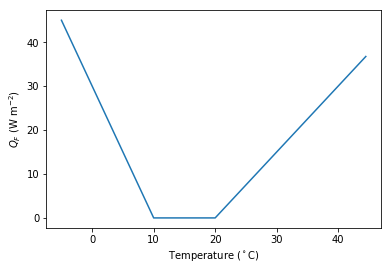

In [30]:
ser_temp=pd.Series(np.arange(-5,45,0.5)).rename('temp_C')
ser_qf=ser_temp.map(QF_simple).rename('qf')
df_temp_qf=pd.concat([ser_temp,ser_qf],axis=1).set_index('temp_C')
ax_qf_func=df_temp_qf.plot()
ax_qf_func.set_xlabel('Temperature ($^\circ$C)');
ax_qf_func.set_ylabel('$Q_F$ ($ \mathrm{W \ m^{-2}}$)');
ax_qf_func.legend().remove()

### spinup for summer and winter run

In [6]:
%%time
# spinup run from January to June
df_output_june, df_state_jul = sp.run_supy(df_forcing.loc[:'2012 6'], df_state_init)
df_state_jul_init = df_state_jul.reset_index('datetime',drop=True).iloc[[-1]]

CPU times: user 10.7 s, sys: 292 ms, total: 11 s
Wall time: 11 s


In [7]:
%%time
# spinup run from July to October
df_output_oct, df_state_dec = sp.run_supy(df_forcing.loc['2012 7':'2012 11'], df_state_jul_init)
df_state_dec_init = df_state_dec.reset_index('datetime',drop=True).iloc[[-1]]

CPU times: user 9.02 s, sys: 229 ms, total: 9.25 s
Wall time: 9.28 s


## communication between `supy` and  `QF_simple`

### construct a new coupled function

In [8]:
# load extra low-level functions from supy to construct interactive functions
from supy.supy_run import suews_cal_tstep, pack_grid_dict
from supy.supy_post import pack_df_output, pack_df_state

def run_supy_qf(df_forcing_test,df_state_init_test):
#     df_state_init_test = df_state_jul_init.copy()
    df_state_init_test.loc[1, 'emissionsmethod'] = 0

    t2_ext = df_forcing_test.iloc[0].temp_c
    qf_ext = QF_simple(t2_ext)

    # initialise dicts for holding results
    dict_state = {}
    dict_output = {}
    
    # starting tstep
    t_start = df_forcing_test.index[0]
    # convert df to dict with `itertuples` for better performance
    dict_forcing = {row.Index: row._asdict()
                    for row in df_forcing_test.itertuples()}
    # dict_state is used to save model states for later use
    dict_state = {
        (t_start, grid): pack_grid_dict(series_state_init)
        for grid, series_state_init
        in df_state_init_test.iterrows()
    }

    grid = 1

    for tstep in df_forcing_test.index:
        # load met forcing at `tstep`
        met_forcing_tstep = dict_forcing[tstep]
        # inject `qf_ext` to `met_forcing_tstep`
        met_forcing_tstep['qf_obs'] = qf_ext

        # update model state
        dict_state_start = dict_state[(tstep, grid)]

        dict_state_end, dict_output_tstep = suews_cal_tstep(dict_state_start, met_forcing_tstep)
        t2_ext = dict_output_tstep['dataoutlinesuews'][-3]
        qf_ext = QF_simple(t2_ext)

        dict_output.update({(tstep, grid): dict_output_tstep})
        dict_state.update({(tstep + 1, grid): dict_state_end})

    # pack results as easier DataFrames
    df_output_test = pack_df_output(dict_output).swaplevel(0, 1)
    df_state_test = pack_df_state(dict_state).swaplevel(0, 1)
    return df_output_test.loc[1,'SUEWS'],df_state_test

### simulations for summer and winter months

In [9]:
%%time
df_output_test_summer,df_state_summer_test=run_supy_qf(df_forcing.loc['2012 7'],df_state_jul_init.copy())
df_output_test_winter,df_state_winter_test=run_supy_qf(df_forcing.loc['2012 12'],df_state_dec_init.copy())

CPU times: user 46.4 s, sys: 1.26 s, total: 47.6 s
Wall time: 48.4 s


### examine the results

#### sumer

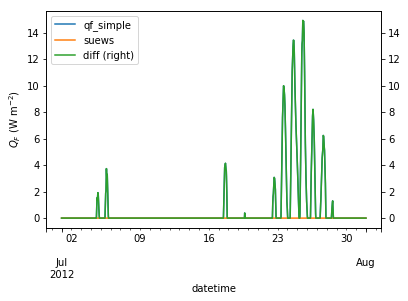

In [12]:
var='QF'
var_label='$Q_F$ ($ \mathrm{W \ m^{-2}}$)'
period='2012 7'
df_test=df_output_test_summer
y1=df_test.loc[period,var].rename('qf_simple')
y2=df_output_def.loc[period,var].rename('suews')
y3=(y1-y2).rename('diff')
df_plot=pd.concat([y1,y2,y3],axis=1)
ax=df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label);
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')

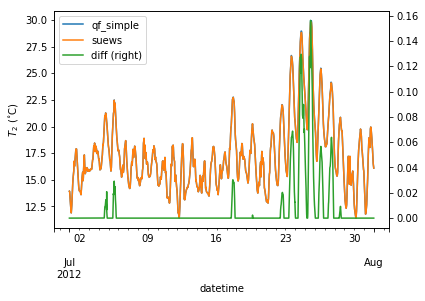

In [13]:
var='T2'
var_label='$T_2$ ($^{\circ}$C)'
period='2012 7'
df_test=df_output_test_summer
y1=df_test.loc[period,var].rename('qf_simple')
y2=df_output_def.loc[period,var].rename('suews')
y3=(y1-y2).rename('diff')
df_plot=pd.concat([y1,y2,y3],axis=1)
ax=df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label);
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')

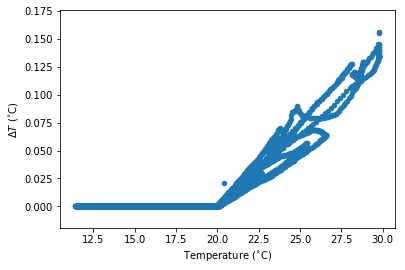

In [22]:
ax_t2diff=df_plot.plot.scatter(x='suews',y='diff')
ax_t2diff.set_ylabel('$\Delta T$ ($^{\circ}$C)');
ax_t2diff.set_xlabel('Temperature ($^{\circ}$C)');

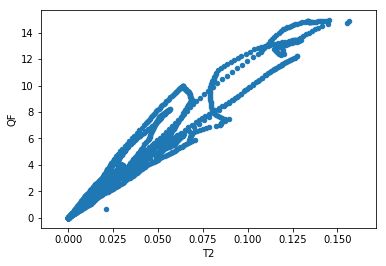

In [24]:
(df_output_test_summer-df_output_def).dropna(how='all',axis=0).loc[:,['QF','T2']].plot.scatter(x='T2',y='QF')

#### winter

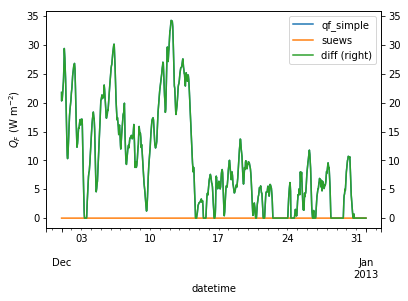

In [25]:
var='QF'
var_label='$Q_F$ ($ \mathrm{W \ m^{-2}}$)'
period='2012 12'
df_test=df_output_test_winter
y1=df_test.loc[period,var].rename('qf_simple')
y2=df_output_def.loc[period,var].rename('suews')
y3=(y1-y2).rename('diff')
df_plot=pd.concat([y1,y2,y3],axis=1)
ax=df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label);
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')

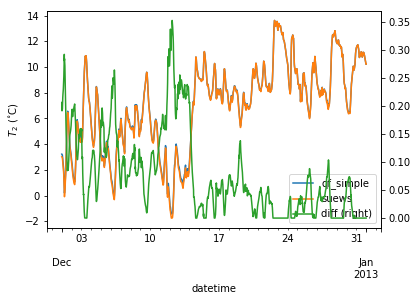

In [26]:
var='T2'
var_label='$T_2$ ($^{\circ}$C)'
period='2012 12'
df_test=df_output_test_winter
y1=df_test.loc[period,var].rename('qf_simple')
y2=df_output_def.loc[period,var].rename('suews')
y3=(y1-y2).rename('diff')
df_plot=pd.concat([y1,y2,y3],axis=1)
ax=df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label);
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')

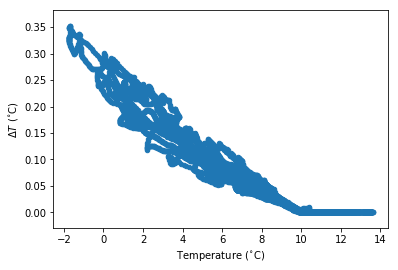

In [27]:
ax_t2diff=df_plot.plot.scatter(x='suews',y='diff')
ax_t2diff.set_ylabel('$\Delta T$ ($^{\circ}$C)');
ax_t2diff.set_xlabel('Temperature ($^{\circ}$C)');

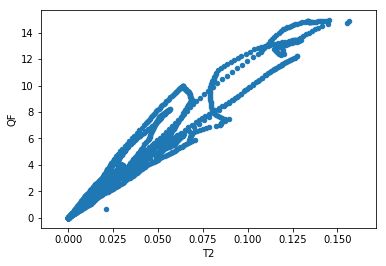

In [28]:
(df_output_test_summer-df_output_def).dropna(how='all',axis=0).loc[:,['QF','T2']].plot.scatter(x='T2',y='QF')